<a href="https://colab.research.google.com/github/adrijacs/Network-Intrusion-Detection/blob/main/NetworkIntrusionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import warnings
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,VotingClassifier,GradientBoostingClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import BernoulliNB
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
import itertools
from xgboost import XGBClassifier
from tabulate import tabulate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train=pd.read_csv('/content/drive/MyDrive/Network intrusion Detection Datasets/Train_data.csv')


In [ ]:
test=pd.read_csv('/content/drive/MyDrive/Network intrusion Detection Datasets/Test_data.csv')


In [ ]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [ ]:
train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.0,25192.0,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,0.001548,0.001350,0.249841,0.014727,0.000357,0.004327,0.0,0.0,0.009130,84.591180,27.698754,0.286338,0.283762,0.118630,0.120260,0.660559,0.062363,0.095931,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,0.039316,0.048785,11.500842,0.529602,0.018898,0.098524,0.0,0.0,0.095115,114.673451,72.468242,0.447312,0.447599,0.318745,0.322335,0.439637,0.178550,0.256583,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,144.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,1.000000,2.000000,975.000000,40.000000,1.000000,8.000000,0.0,0.0,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
train.describe(include='object')

,protocol_type,service,flag,class
count,25192,25192,25192,25192
unique,3,66,11,2
top,tcp,http,SF,normal
freq,20526,8003,14973,13449


In [ ]:
train.shape

(25192, 42)

In [ ]:
train.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [ ]:
total=train.shape[0]
missing_columns=[col for col in train.columns if train[col].isnull().sum()>0]
for col in missing_columns:
  null_count=train[col].isnull().sum()
  per=(null_count/total)*100
  print(f"{col}:{null_count} ({round(per,3)}%)")

In [ ]:
print(f"Number of duplicate rows: {train.duplicated().sum()}")

Number of duplicate rows: 0


<Axes: xlabel='class', ylabel='count'>

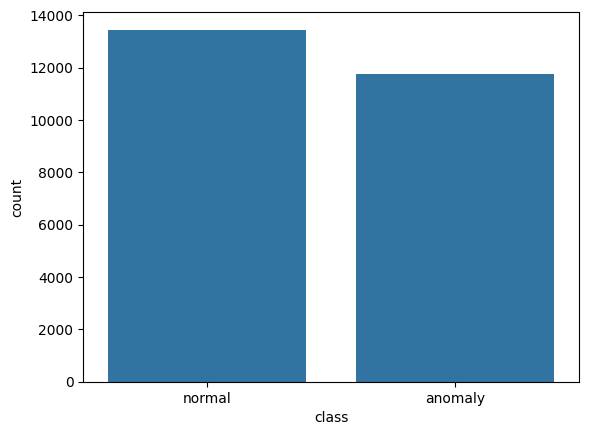

In [ ]:
sns.countplot(x=train['class'])

In [ ]:
print('Class distribution Training set:')
print(train['class'].value_counts())

Class distribution Training set:
normal     13449
anomaly    11743
Name: class, dtype: int64


In [ ]:
def le(df):
  for col in df.columns:
    if(df[col].dtype=='object'):
      label_encoder=LabelEncoder()
      df[col]=label_encoder.fit_transform(df[col])

le(train)
le(test)


In [ ]:
train.drop(['num_outbound_cmds'],axis=1,inplace=True)
test.drop(['num_outbound_cmds'],axis=1,inplace=True)

In [ ]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,1,19,9,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1
1,0,2,41,9,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,1
2,0,1,46,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0
3,0,1,22,9,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1
4,0,1,22,9,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1


In [ ]:
x_train=train.drop(['class'],axis=1)
Y_train=train['class']

In [ ]:
rfc=RandomForestClassifier()
rfe=RFE(rfc,n_features_to_select=10)
rfe=rfe.fit(x_train,Y_train)
feature_map=[(i,v) for i,v in itertools.zip_longest(rfe.get_support(),x_train.columns)]
selected_features=[v for i,v in feature_map if i==True]
selected_features

['protocol_type',
 'flag',
 'src_bytes',
 'dst_bytes',
 'count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_same_src_port_rate']

In [ ]:
x_train=x_train[selected_features]


In [ ]:
scale=StandardScaler()
x_train=scale.fit_transform(x_train)
test=scale.fit_transform(test)

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x_train,Y_train,train_size=0.70,random_state=2)

In [ ]:
x_train.shape

(17634, 10)

In [ ]:
x_test.shape

(7558, 10)

In [ ]:
y_train.shape

(17634,)

In [ ]:
y_test.shape

(7558,)

In [ ]:
import time

In [ ]:
from sklearn.linear_model import LogisticRegression
clfl=LogisticRegression(max_iter=1200000)
start_time=time.time()
clfl.fit(x_train,y_train.values.ravel())
end_time=time.time()
print('training time:',end_time-start_time)

training time: 0.0845785140991211


In [ ]:
start_time=time.time()
y_test_pred=clfl.predict(x_train)
end_time=time.time()
print('testing time:',end_time-start_time)

testing time: 0.010955810546875


In [ ]:
lg_model=LogisticRegression(random_state=42)
lg_model.fit(x_train,y_train)

LogisticRegression(random_state=42)

In [ ]:
lg_train,lg_test=lg_model.score(x_train,y_train),lg_model.score(x_test,y_test)
print('Training Score:',lg_train)
print('Test score:',lg_test)

Training Score: 0.9418169445389588
Test score: 0.938872717650172


In [ ]:
pip install optuna

In [ ]:
import optuna

In [ ]:
def objective(trial):
  n_neighbors=trial.suggest_int('KNN_n_neighbors',2,16,log=False)
  classifier_obj=KNeighborsClassifier(n_neighbors=n_neighbors)
  classifier_obj.fit(x_train,y_train)
  accuracy=classifier_obj.score(x_test,y_test)
  return accuracy

In [ ]:
study_KNN=optuna.create_study(direction='maximize')
study_KNN.optimize(objective,n_trials=1)
print(study_KNN.best_trial)

[I 2024-03-09 03:42:39,512] A new study created in memory with name: no-name-20239bc4-14b8-483c-b6eb-a5784fca826c
[I 2024-03-09 03:42:41,638] Trial 0 finished with value: 0.980021169621593 and parameters: {'KNN_n_neighbors': 10}. Best is trial 0 with value: 0.980021169621593.


FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.980021169621593], datetime_start=datetime.datetime(2024, 3, 9, 3, 42, 39, 520506), datetime_complete=datetime.datetime(2024, 3, 9, 3, 42, 41, 638497), params={'KNN_n_neighbors': 10}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'KNN_n_neighbors': IntDistribution(high=16, log=False, low=2, step=1)}, trial_id=0, value=None)


In [ ]:
KNN_model=KNeighborsClassifier(n_neighbors=study_KNN.best_trial.params['KNN_n_neighbors'])
KNN_model.fit(x_train,y_train)
KNN_train,KNN_test=KNN_model.score(x_train,y_train),KNN_model.score(x_test,y_test)
print('train score:',KNN_train)
print('test score:',KNN_test)

train score: 0.9824203243733697
test score: 0.980021169621593


In [ ]:
from sklearn.tree import DecisionTreeClassifier
clfd=DecisionTreeClassifier(criterion="entropy",max_depth=4)
start_time=time.time()
clfd.fit(x_train,y_train.values.ravel())
end_time=time.time()
print('training time:',end_time-start_time)

training time: 0.027964115142822266


In [ ]:
start_time=time.time()
y_test_pred=clfd.predict(x_train)
end_time=time.time()
print('testing time',end_time-start_time)

testing time 0.002274036407470703


In [ ]:
def objective(trial):
  dt_max_depth=trial.suggest_int('dt_max_depth',2,32,log=False)
  dt_max_features=trial.suggest_int('dt_max_features',2,10,log=False)
  classifier_obj=DecisionTreeClassifier(max_features=dt_max_features,max_depth=dt_max_depth)
  classifier_obj.fit(x_train,y_train)
  accuracy=classifier_obj.score(x_test,y_test)
  return accuracy

In [ ]:
study_dt=optuna.create_study(direction="maximize")
study_dt.optimize(objective,n_trials=10)
print(study_dt.best_trial)

[I 2024-03-09 03:49:43,157] A new study created in memory with name: no-name-441cf939-cbdd-47ba-a13d-292e6b582480
[I 2024-03-09 03:49:43,184] Trial 0 finished with value: 0.9847843344800211 and parameters: {'dt_max_depth': 5, 'dt_max_features': 7}. Best is trial 0 with value: 0.9847843344800211.
[I 2024-03-09 03:49:43,215] Trial 1 finished with value: 0.9944429743318338 and parameters: {'dt_max_depth': 13, 'dt_max_features': 7}. Best is trial 1 with value: 0.9944429743318338.
[I 2024-03-09 03:49:43,237] Trial 2 finished with value: 0.9928552527123577 and parameters: {'dt_max_depth': 16, 'dt_max_features': 4}. Best is trial 1 with value: 0.9944429743318338.
[I 2024-03-09 03:49:43,256] Trial 3 finished with value: 0.9567345858692776 and parameters: {'dt_max_depth': 4, 'dt_max_features': 5}. Best is trial 1 with value: 0.9944429743318338.
[I 2024-03-09 03:49:43,284] Trial 4 finished with value: 0.9931198729822704 and parameters: {'dt_max_depth': 32, 'dt_max_features': 5}. Best is trial 1 

FrozenTrial(number=9, state=TrialState.COMPLETE, values=[0.9948399047367028], datetime_start=datetime.datetime(2024, 3, 9, 3, 49, 43, 432007), datetime_complete=datetime.datetime(2024, 3, 9, 3, 49, 43, 480574), params={'dt_max_depth': 12, 'dt_max_features': 10}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dt_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'dt_max_features': IntDistribution(high=10, log=False, low=2, step=1)}, trial_id=9, value=None)


In [ ]:
dt = DecisionTreeClassifier(max_features = study_dt.best_trial.params['dt_max_features'], max_depth = study_dt.best_trial.params['dt_max_depth'])
dt.fit(x_train, y_train)

dt_train, dt_test = dt.score(x_train, y_train), dt.score(x_test, y_test)

print(f"Train Score: {dt_train}")
print(f"Test Score: {dt_test}")

Train Score: 0.9992627877963026
Test Score: 0.9949722148716592


In [ ]:
data = [["KNN", KNN_train, KNN_test],
        ["Logistic Regression", lg_train, lg_test],
        ["Decision Tree", dt_train, dt_test]]

col_names = ["Model", "Train Score", "Test Score"]
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))


╒═════════════════════╤═══════════════╤══════════════╕
│ Model               │   Train Score │   Test Score │
╞═════════════════════╪═══════════════╪══════════════╡
│ KNN                 │      0.98242  │     0.980021 │
├─────────────────────┼───────────────┼──────────────┤
│ Logistic Regression │      0.941817 │     0.938873 │
├─────────────────────┼───────────────┼──────────────┤
│ Decision Tree       │      0.999263 │     0.994972 │
╘═════════════════════╧═══════════════╧══════════════╛


In [ ]:
SEED = 42

# Decision Tree Model
dtc = DecisionTreeClassifier()

# KNN
knn = KNeighborsClassifier()

# LOGISTIC REGRESSION MODEL

lr = LogisticRegression()


In [ ]:
from sklearn.model_selection import cross_val_score
models = {}
models['KNeighborsClassifier']= knn
models['LogisticRegression']= lr
models['DecisionTreeClassifier']= dtc

In [ ]:
scores = {}
for name in models:
  scores[name]={}
  for scorer in ['precision','recall']:
    scores[name][scorer] = cross_val_score(models[name], x_train, y_train, cv=10, scoring=scorer)

In [ ]:
def line(name):
  return '*'*(25-len(name)//2)

for name in models:
  print(line(name), name, 'Model Validation', line(name))

  for scorer in ['precision','recall']:
    mean = round(np.mean(scores[name][scorer])*100,2)
    stdev = round(np.std(scores[name][scorer])*100,2)
    print ("Mean {}:".format(scorer),"\n", mean,"%", "+-",stdev)
    print()


*************** KNeighborsClassifier Model Validation ***************
Mean precision: 
 98.39 % +- 0.41

Mean recall: 
 98.3 % +- 0.44

**************** LogisticRegression Model Validation ****************
Mean precision: 
 93.57 % +- 0.63

Mean recall: 
 95.64 % +- 0.6

************** DecisionTreeClassifier Model Validation **************
Mean precision: 
 99.43 % +- 0.21

Mean recall: 
 99.46 % +- 0.17



<Axes: >

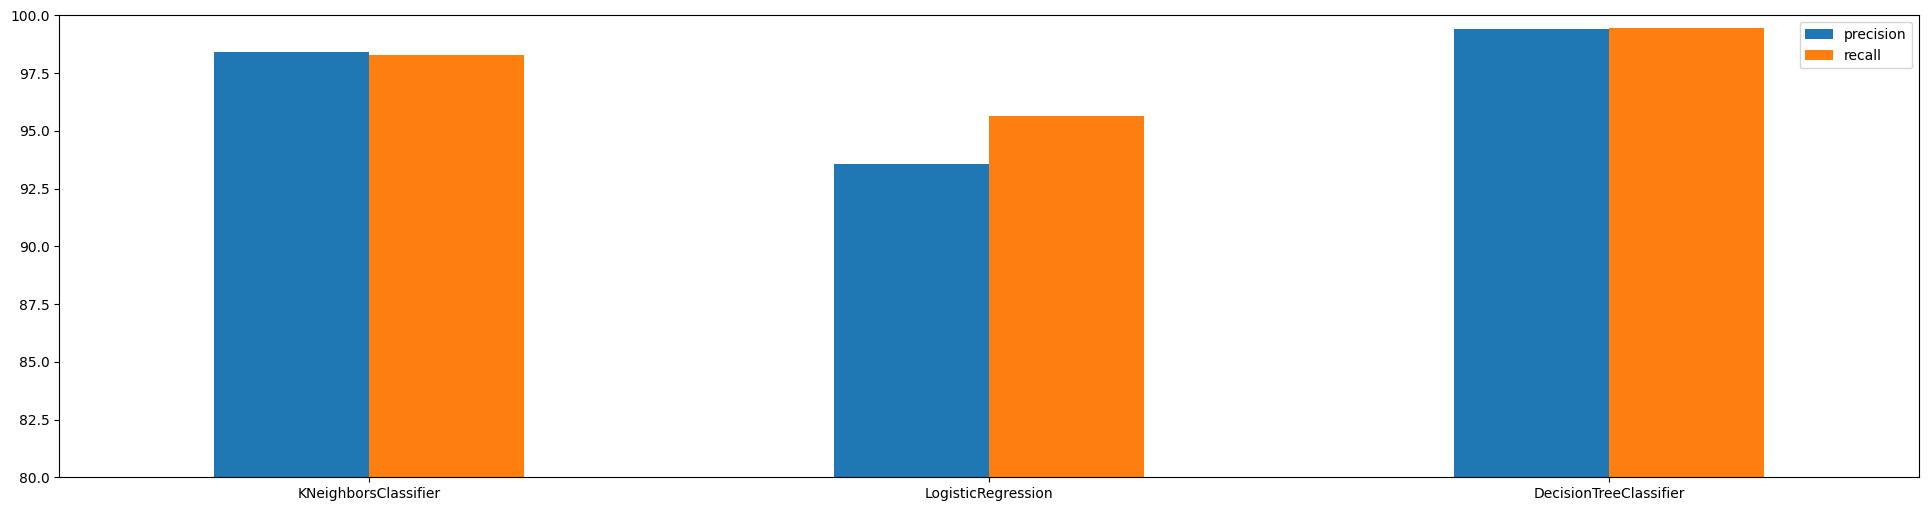

In [ ]:
for name in models:
    for scorer in ['precision','recall']:
        scores[name][scorer] = scores[name][scorer].mean()
scores=pd.DataFrame(scores).swapaxes("index", "columns")*100
scores.plot(kind = "bar",  ylim=[80,100], figsize=(24,6), rot=0)


In [ ]:
models = {}
models['KNeighborsClassifier']= knn
models['LogisticRegression']= lr
models['DecisionTreeClassifier']= dtc


In [ ]:
preds={}
for name in models:
    models[name].fit(x_train, y_train)
    preds[name] = models[name].predict(x_test)
print("Predictions complete.")


Predictions complete.


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
def line(name,sym="*"):
    return sym*(25-len(name)//2)
target_names=["normal","anamoly"]
for name in models:
    print(line(name), name, 'Model Testing', line(name))
    print(confusion_matrix(y_test, preds[name]))
    print(line(name,'-'))
    print(classification_report(y_test, preds[name], target_names=target_names))

*************** KNeighborsClassifier Model Testing ***************
[[3423   75]
 [  57 4003]]
---------------
              precision    recall  f1-score   support

      normal       0.98      0.98      0.98      3498
     anamoly       0.98      0.99      0.98      4060

    accuracy                           0.98      7558
   macro avg       0.98      0.98      0.98      7558
weighted avg       0.98      0.98      0.98      7558

**************** LogisticRegression Model Testing ****************
[[3224  274]
 [ 188 3872]]
----------------
              precision    recall  f1-score   support

      normal       0.94      0.92      0.93      3498
     anamoly       0.93      0.95      0.94      4060

    accuracy                           0.94      7558
   macro avg       0.94      0.94      0.94      7558
weighted avg       0.94      0.94      0.94      7558

************** DecisionTreeClassifier Model Testing **************
[[3477   21]
 [  20 4040]]
--------------
              pr

<Axes: >

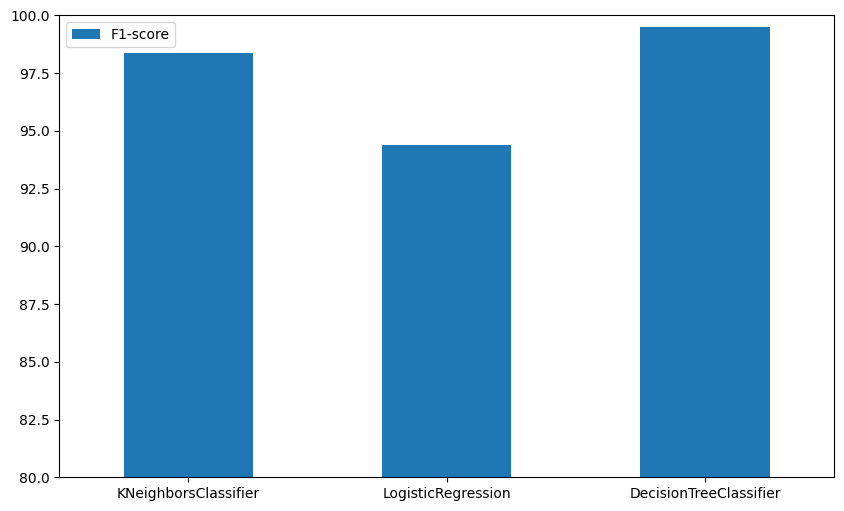

In [ ]:
f1s = {}
for name in models:
    f1s[name]=f1_score(y_test, preds[name])
f1s=pd.DataFrame(f1s.values(),index=f1s.keys(),columns=["F1-score"])*100
f1s.plot(kind = "bar",  ylim=[80,100], figsize=(10,6), rot=0)
